In [0]:
from __future__ import print_function, division
from pathlib import Path
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from IPython.core.debugger import set_trace
import cv2
from PIL import Image
import random

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

path = Path('drive/My Drive/Colab/Ear_Project')
if not os.path.exists('./dataset'):
   os.chdir(path)

#reproducibility

random.seed(420)
torch.manual_seed(420)
torch.cuda.manual_seed(420)
np.random.seed(420)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [0]:
class AutoCanny():
  def __call__(self,sample):
    img, label = sample['image'], sample['label']
    img = np.asarray(img)
    img = cv2.bilateralFilter(img, 4, 70, 110)
    img = auto_canny(img)

    return {'image': img.astype(np.float32) ,'label': label}

class Resize():
  def __call__(self,sample):
    img, label = sample['image'], sample['label']
    h, w = img.size[:2]
    padding = (max(0,h-w), max(0,w-h))
    img = transforms.functional.pad(img, padding)
    img = np.asarray(img)
    img = cv2.resize(img,(96,96),interpolation = cv2.INTER_AREA)

    return {'image': img, 'label': label}


class ToTensor(object):
  """Convert ndarrays in sample to Tensors."""

  def __call__(self, sample):
      img, label = (sample['image'], sample['label'])      
      # swap color axis because
      # numpy image: H x W x C
      # torch image: C X H X W
      img = img.reshape(96,96,1)
      img = img.transpose((2, 0, 1))
      return {'image': torch.from_numpy(img), 'label': torch.from_numpy(label)}

class Normalize():
  def __init__(self, mean, std, inplace=False):
    self.mean = mean
    self.std = std
    self.inplace = inplace

  def __call__(self, sample):
    img, label = sample['image'], sample['label']

    return transforms.functional.normalize(img, self.mean, self.std, self.inplace), label


def auto_canny(image, sigma=0.6):
	v = np.median(image)
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)

	return edged
  #edged.astype(np.float32)


def show_batch(batch):
  images_batch, label = batch

  grid = utils.make_grid(images_batch)
  for img in images_batch:
    print (img.shape)
    # print(f'Min pixel value: {min(img)},\nMax pixel value: {max(img)}')
  plt.imshow(grid.numpy().transpose(1,2,0))



In [0]:
class CNNNet(nn.Module):
  def __init__(self):
    super(CNNNet, self).__init__()
    self.features = nn.Sequential(
      nn.Conv2d(1, 16, 3, padding=1),
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),
      nn.Conv2d(16, 16, kernel_size=3, padding=1),
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
    )
    self.classifier = nn.Sequential(
      nn.Linear(16*24*24, 1000),
      nn.Linear(1000, 100),
      nn.Linear(100, 8),
    )
  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

net = CNNNet().cuda()

In [0]:
from sklearn.preprocessing import scale

def standard(img):
  return (img - np.mean(img)) / np.std(img)

class EarDataset(Dataset):

  def __init__(self, pkl_file, root_dir, transform=None):
    self.dataset = pd.read_pickle(pkl_file)
    self.root_dir = root_dir
    self.transform = transform
      
  def __len__(self):
    return len(self.dataset)


  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    img_name = os.path.join(self.root_dir, self.dataset.iloc[idx, 0])
    image = Image.open(img_name)
    image = image.convert('L')
    # image = scale(image, axis=0, with_mean=True, with_std=True, copy=True )
    # image = standard(image)
    # image = cv2.resize(image,(96,96),interpolation = cv2.INTER_AREA)
    # image = image.reshape(96,96,1)
    label = self.dataset.iloc[idx,1].astype(np.float32)
    sample = {'image': image, 'label': label}


    if self.transform:
      sample = self.transform(sample)
    return sample


class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.subset[index]
        if self.transform:
            img, label = self.transform((img, label))
        return img, label

    def __len__(self):
        return len(self.subset)

In [0]:
transform = transforms.Compose([Resize(),
                              AutoCanny(),
                              ToTensor(),
                              Normalize([0],[255]),
                              ])
dataset2 = 'dataset2_3D3A.pkl'
dataset3 = 'dataset3_ITA.pkl'
pkl_file = os.path.join('dataset_original', dataset3)

root_dir_canny = 'dataset'
root_dir_original = 'dataset_original/dataset3'

init_dataset = EarDataset(pkl_file=pkl_file, root_dir=root_dir_original, transform=transform)

lengths = [38, 10]

train_subset, test_subset = random_split(init_dataset, lengths)

train_dataset = DatasetFromSubset(train_subset, transform=None)
test_dataset = DatasetFromSubset(test_subset, transform=None)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4)

In [0]:
transform = transforms.Compose([Resize(),
                              AutoCanny(),
                              ToTensor(),
                              Normalize([0],[255]),
                              ])

pkl_file = 'dataset109.pkl'

root_dir_canny = 'dataset'
root_dir_original = 'dataset_original/dataset'

init_dataset = EarDataset(pkl_file=pkl_file, root_dir=root_dir_original, transform=transform)

lengths = [87, 22]

train_subset, test_subset = random_split(init_dataset, lengths)

train_dataset = DatasetFromSubset(train_subset, transform=None)
test_dataset = DatasetFromSubset(test_subset, transform=None)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [69]:
torch.max(train_subset[0][0])

tensor(1.)

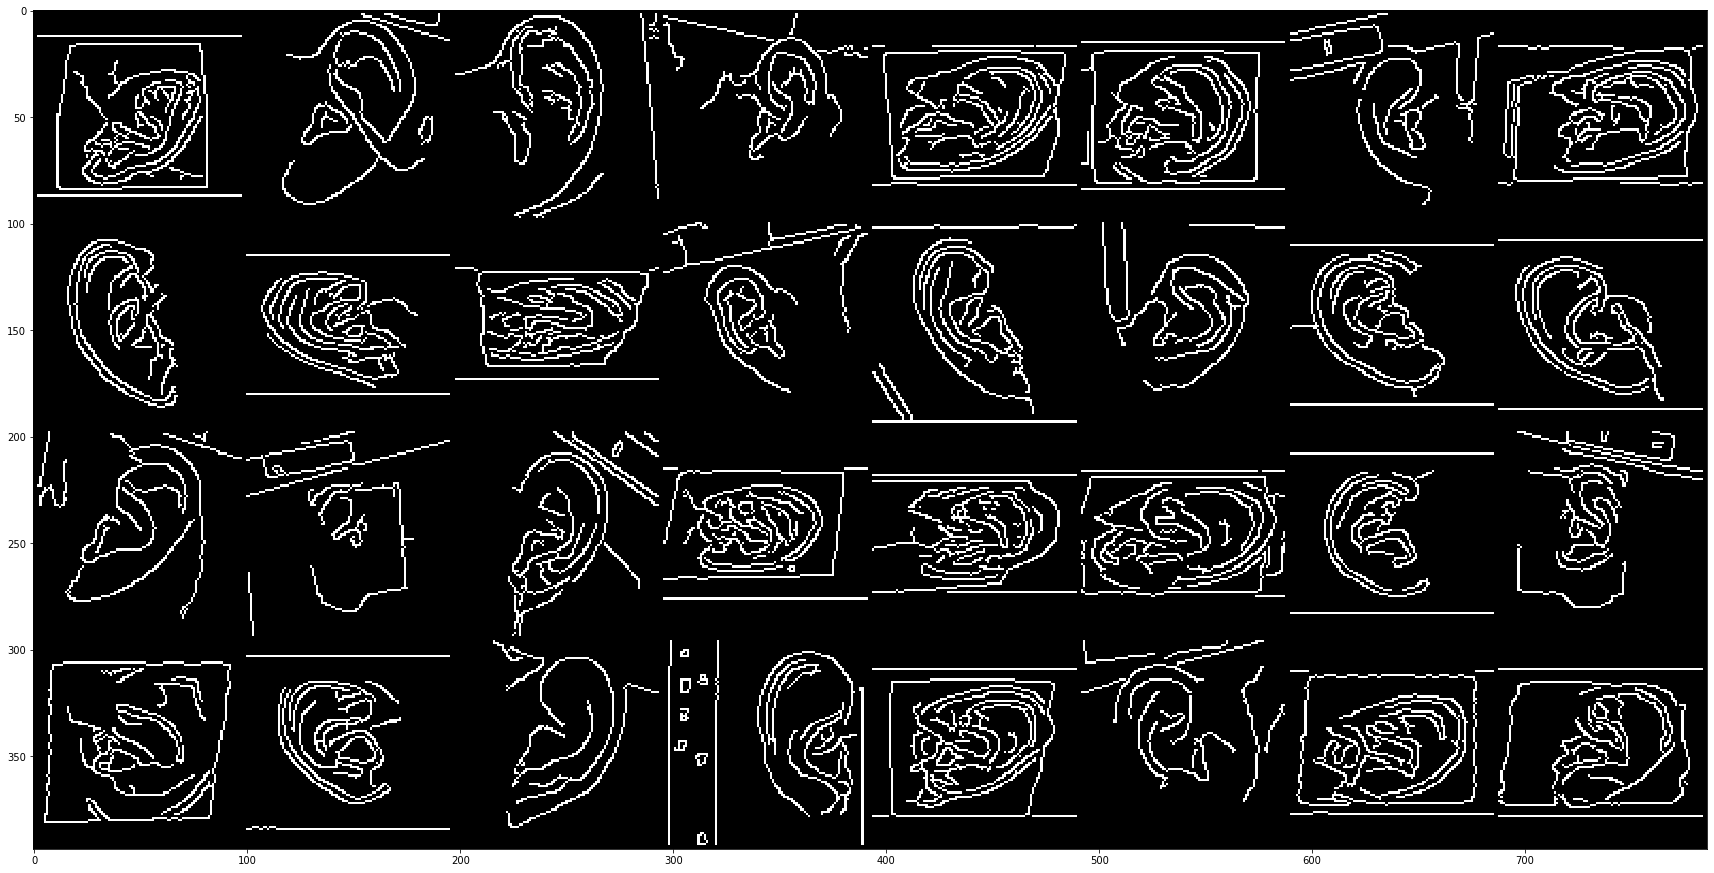

In [70]:
def show_batch(batch):
  images_batch, label = batch

  grid = utils.make_grid(images_batch)
  # for img in images_batch:
  #   print(f'Min pixel value: {torch.min(img)},\nMax pixel value: {torch.max(img)},\nType {img.type()},\nShape {img.shape}')
  plt.figure(figsize=(30,30))
  plt.imshow(grid.numpy().transpose(1,2,0))

batch = next(iter(train_dataloader))
show_batch(batch)

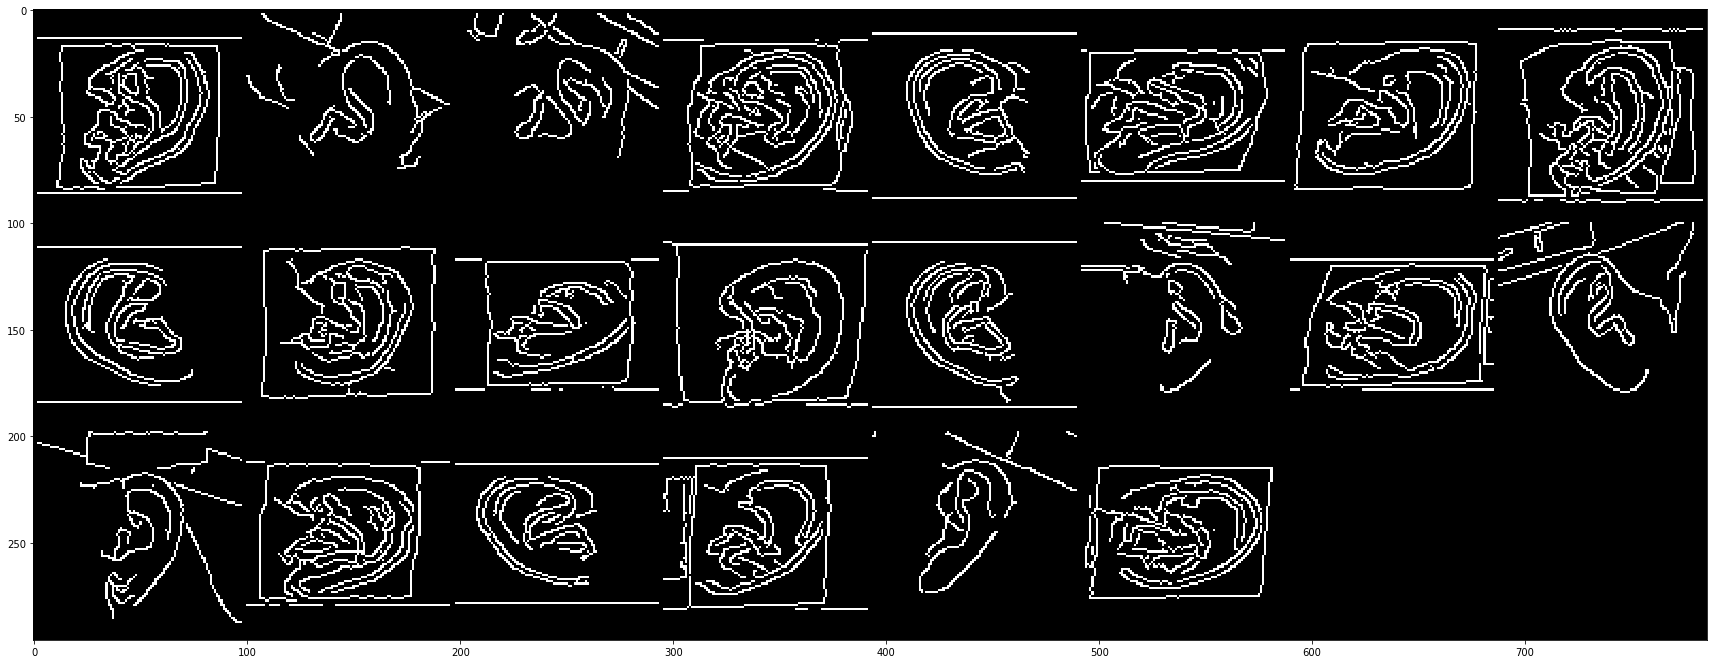

In [71]:
batch = next(iter(test_dataloader))
show_batch(batch)

In [0]:

def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()


def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
  model.apply(weight_reset)
  for epoch in range(epochs):
    training_loss = 0.0
    valid_loss = 0.0
    model.train()
    for batch in train_loader:
      optimizer.zero_grad()
      inputs, target = batch
      inputs = inputs.to(device)
      target = target.to(device)
      output = model(inputs)
      loss = loss_fn(output, target)
      loss.backward()
      optimizer.step()
      training_loss += loss.item()
      train_error = torch.dist(target, output)
    training_loss /= len(train_loader)

    model.eval()
    num_correct = 0
    num_examples = 0
    for batch in val_loader:
      inputs, targets = batch
      inputs = inputs.to(device)
      output = model(inputs)
      targets = targets.to(device)
      loss = loss_fn(output,targets)
      valid_loss += loss.item()
      val_error = torch.dist(targets, output)
    valid_loss /= len(val_loader)

    print(f'Epoch: {epoch}, Training Loss: {training_loss}, Validation Loss: {valid_loss}, Train Error = {train_error}, Validation Error = {val_error}')


In [73]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.00005)

train(model=net, optimizer=optimizer, loss_fn=criterion,
      train_loader=train_dataloader, val_loader=test_dataloader,
      epochs=10, device="cuda")


Epoch: 0, Training Loss: 4.458492437998454, Validation Loss: 6.461160182952881, Train Error = 16.263696670532227, Validation Error = 33.721866607666016
Epoch: 1, Training Loss: 0.8248983025550842, Validation Loss: 4.24753999710083, Train Error = 15.270787239074707, Validation Error = 27.341670989990234
Epoch: 2, Training Loss: 1.5639594793319702, Validation Loss: 3.3926525115966797, Train Error = 16.015132904052734, Validation Error = 24.43577003479004
Epoch: 3, Training Loss: 0.7444293101628622, Validation Loss: 3.273834228515625, Train Error = 8.534796714782715, Validation Error = 24.004058837890625
Epoch: 4, Training Loss: 0.2147920827070872, Validation Loss: 3.27439546585083, Train Error = 7.517035961151123, Validation Error = 24.00611686706543
Epoch: 5, Training Loss: 0.4934867024421692, Validation Loss: 2.9437777996063232, Train Error = 10.385676383972168, Validation Error = 22.761919021606445
Epoch: 6, Training Loss: 0.4810209572315216, Validation Loss: 2.1842751502990723, Train

In [74]:
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.00005)

train(model=net, optimizer=optimizer, loss_fn=criterion,
      train_loader=train_dataloader, val_loader=test_dataloader,
      epochs=10, device="cuda")


Epoch: 0, Training Loss: 4.59252405166626, Validation Loss: 0.423922061920166, Train Error = 15.949946403503418, Validation Error = 8.637724876403809
Epoch: 1, Training Loss: 1.0925273696581523, Validation Loss: 1.8346405029296875, Train Error = 17.89887046813965, Validation Error = 17.969327926635742
Epoch: 2, Training Loss: 1.7923738559087117, Validation Loss: 0.7233573794364929, Train Error = 16.005897521972656, Validation Error = 11.283212661743164
Epoch: 3, Training Loss: 0.7037246922651926, Validation Loss: 0.31512394547462463, Train Error = 8.737442970275879, Validation Error = 7.447268486022949
Epoch: 4, Training Loss: 0.31290772557258606, Validation Loss: 0.7418885827064514, Train Error = 7.770503520965576, Validation Error = 11.426828384399414
Epoch: 5, Training Loss: 0.6100664933522543, Validation Loss: 0.8044927716255188, Train Error = 11.366907119750977, Validation Error = 11.899189949035645
Epoch: 6, Training Loss: 0.48272013664245605, Validation Loss: 0.36024734377861023

Epoch: 99, Training Loss: 0.00010694790489651496, Validation Loss: 0.0673814918845892, pnorm = 1.5491362810134888

Epoch: 99, Training Loss: 0.00013848422713635955, Validation Loss: 0.09261073172092438, pnorm = 1.6659570932388306

In [75]:
path = 'testset/0051_left.jpg'
target = torch.tensor([1.7321, 0.82316, 1.7177, 1.3736, 5.94, 2.8194, 0.57672, 1.0697]).to('cuda')
image = Image.open(path)
sample_pred = {'image': image, 'label': np.random.randn(8)}
transformed_sample = transform(sample_pred)
img = transformed_sample[0].unsqueeze(0).to('cuda')
print(torch.max(img))
prediction = net(img)
error = torch.dist(target, prediction)
print(prediction)
print(error)

tensor(1., device='cuda:0')
tensor([[2.0391, 0.7662, 2.0500, 1.9276, 7.2200, 2.9394, 0.7247, 1.0247]],
       device='cuda:0', grad_fn=<AddmmBackward>)
tensor(1.4804, device='cuda:0', grad_fn=<DistBackward>)



Previsão: 1.8504, 0.4400, 1.5174, 1.2913, 6.1952, 2.9311, 0.4214, 1.0045

Valor real: 1.7321	0.82316	1.7177	1.3736	5.94	2.8194	0.57672	1.0697